# postKinectのサンプルプログラム

## 実行環境
anaconda 2020.11をインストール後，下記モジュールをインストールし，JupyterLabを起動する．
```
pip install pyvista

pip install opencv-python
pip install opencv-contrib-python

conda install nodejs
pip install itkwidgets
jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib jupyterlab-datawidgets itkwidgets
pip install ipywidgets

jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter nbextension enable --py --sys-prefix widgetsnbextension

pip install tqdm
```

In [183]:
import numpy as np
import pyvista as pv
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

import sys, os
from pathlib import Path
#現在の絶対パスを取得
current_dir = Path().resolve()
sys.path.append(str(current_dir) + '/../../')

import postBase
import postCore

## ファイルの読込
- マッピングファイル
- デプスデータファイル
- dsの構造: frameの数(150), 時間(150の配列), \[150×424×512\](150フレームの424×512に対応する深さデータ)

In [184]:
mapTableFName = '../../mapTable_depth_to_3D.dat'
#mappingtableの読み込み
mt = postBase.readMapTable(mapTableFName)
#casedirと同じフォルダ
#背景画像(対象物が移ってないもの)
caseDir_background = '2021-0603-164246_init'
#対象画像
caseDir = '2021-0603-180802_15ms-2' # 10 m/s
#caseDir = '2019-1028-132232' # 12 m/s
#caseDir = '2019-1028-132314' # 14 m/s
#caseDir = '2019-1028-132501' # 16 m/s
#caseDir = '2019-1028-132552' # 18 m/s
#caseDir = '2019-1028-132743' # 20 m/s
#caseDir = '2019-1028-132920' # 18 m/s
#caseDir = '2019-1028-133150' # 16 m/s
#caseDir = '2019-1028-133342' # 14 m/s
#caseDir = '2019-1028-133543' # 12 m/s
#caseDir = '2019-1028-133713' # 10 m/s
#caseDir = '2019-1028-133839' # 10 m/s
#caseDir = '2019-1028-134040' # 10 m/s
#caseDir = '2019-1028-134235' # 10 m/s
#caseDir_background = '2019-1028-134457'
ds_back = postBase.readDepthLogs(caseDir_background)
#nFrame, depthCounts, depthBuffersが返ってくる
ds = postBase.readDepthLogs(caseDir)

 [Info] reading ... : ../../mapTable_depth_to_3D.dat
 [Info] reading ... : 2021-0603-164246_init/depth\depth_00003.dat
   Total Frame : 150
 [Info] reading ... : 2021-0603-180802_15ms-2/depth\depth_00000.dat
   Total Frame : 150


## Bilateralフィルターの適用
- ds_BF:バイラテラルフィルタ適用
- ds:対象物
- ds_back: 背景画像
- ds_front: 背景画像を減算したもの

In [185]:
from tqdm import tqdm

fileName_ds_BF = '/ds_BF.npz'
filePath = caseDir+fileName_ds_BF
if not os.path.exists(filePath):
    ds_BF = []
    #tqdm プログレスバーを表示させる
    for d in tqdm(ds[2]):
        d_BF = postBase.bilateralFilter0(d.astype(np.float32), 5, 5.0, 100.0)
        ds_BF.append(d_BF)
    ds_BF = np.array(ds_BF)
    #npzファイルの生成
    np.savez_compressed(filePath, ds_BF=ds_BF)
else:
    ds_BF = np.load(filePath)['ds_BF']


## ローパスフィルターの適用

In [186]:
'''
fileName_ds_BF_LPF = '/ds_BF_LPF.npy'
if not os.path.exists(caseDir+fileName_ds_BF_LPF):
    ds_BF_LPF = postBase.calcLowpassFilter2(np.array(ds_BF))
    np.save(caseDir+fileName_ds_BF_LPF, ds_BF_LPF)
else:
    ds_BF_LPF = np.load(caseDir+fileName_ds_BF_LPF)
'''
ds[2].shape

(150, 424, 512)

In [187]:
depths = {}
#時間方向
depths['ts'] = ds[1]
#depths['ds_BF_LPF'] = ds_BF_LPF
depths['ds_BF'] = ds_BF
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

nFrame, depthHeight, depthWidth = ds[2].shape

@widgets.interact(i_pixel=(0, depthWidth-1, 1), j_pixel=(0, depthHeight-1, 1))
def plotTimeHistory(i_pixel, j_pixel):
    plt.plot(depths['ts'], depths['ds_BF'][:,j_pixel,i_pixel])
    #plt.plot(depths['ts'], depths['ds_BF_LPF'][:,j_pixel,i_pixel])
    #plt.plot(depths['ts'], depths['ds_back'][:,j_pixel,i_pixel])
    plt.show()
    
    fig, ax = plt.subplots()
    ax.imshow(depths['ds'][0], cmap='gray_r')
    ax.scatter([i_pixel], [j_pixel])
    ax.invert_xaxis()
    plt.show()   

interactive(children=(IntSlider(value=255, description='i_pixel', max=511), IntSlider(value=211, description='…

## デプス画像の表示

In [188]:
depths = {}
#depths['ds_BF_LPF'] = ds_BF_LPF
depths['ds_BF'] = ds_BF
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImageGray(key, nFrame=0):
    #img = postBase.createDepthImageGray(depths[key][nFrame])
    #plt.imshow(img, cmap = 'gray')
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap='gray_r')
    plt.colorbar()
    plt.show()

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImage(key, nFrame=0):
    #img = postBase.createDepthImage(depths[key][nFrame])
    #plt.imshow(img)
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap = 'rainbow')
    plt.colorbar()
    plt.show()
    

interactive(children=(Dropdown(description='key', options=('ds_BF', 'ds', 'ds_back'), value='ds_BF'), IntSlide…

interactive(children=(Dropdown(description='key', options=('ds_BF', 'ds', 'ds_back'), value='ds_BF'), IntSlide…

## デプスの平均値と標準偏差

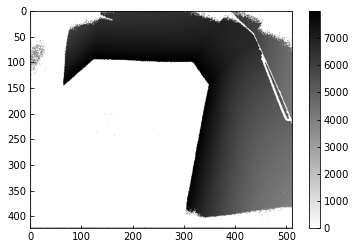

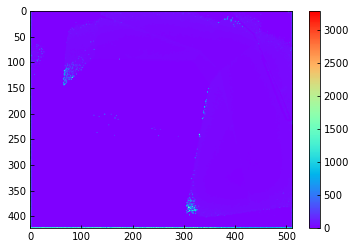

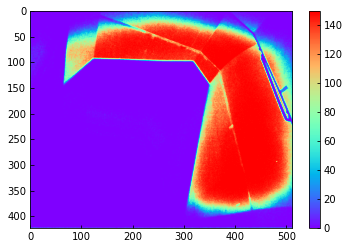

In [189]:
#壁面データ
#平均，標準偏差,nullの数
ds_back_mean, ds_back_std, count_nonzero_back = postBase.calcMeanStd(ds_back[2])

plt.imshow(cv2.flip(ds_back_mean, 1), cmap='gray_r')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(ds_back_std, 1), cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(count_nonzero_back, 1), cmap='rainbow')
plt.colorbar()
plt.show()

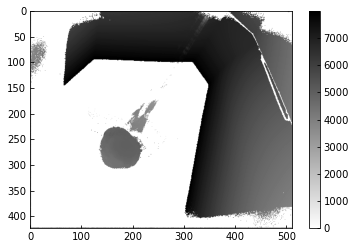

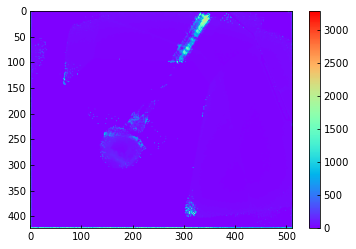

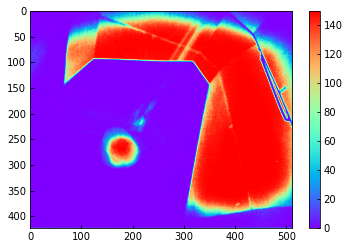

In [190]:
#対象データ
ds_mean, ds_std, count_nonzero = postBase.calcMeanStd(ds[2])

plt.imshow(cv2.flip(ds_mean, 1), cmap='gray_r')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(ds_std, 1), cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(count_nonzero, 1), cmap='rainbow')
plt.colorbar()
plt.show()

## 背景画像からの減算による物体抽出

In [191]:
ds_back_mean, ds_back_std, count_nonzero_back = postBase.calcMeanStd(ds_back[2])

fileName_ds_front = '/ds_front.npz'
filePath = caseDir+fileName_ds_front
if not os.path.exists(filePath):
    #背景画像の減算処理
    ds_front = [postBase.calcFrontground(d, ds_back_mean, threshold=5000) for d in ds[2]]
    ds_front = np.array(ds_front)
    np.savez_compressed(filePath, ds_front=ds_front)
else:
    ds_front = np.load(filePath)['ds_front']
# ds_front = [postBase.calcFrontground(d, ds_back_mean, threshold_depth=4400) for d in ds[2]]

fileName_ds_BF_front = '/ds_BF_front.npz'
filePath = caseDir+fileName_ds_BF_front
if not os.path.exists(filePath):
    ds_BF_front = [postBase.calcFrontground(d, ds_back_mean, threshold_depth=5000) for d in ds_BF]
    ds_BF_front = np.array(ds_front)
    np.savez_compressed(filePath, ds_BF_front=ds_BF_front)
else:
    ds_BF_front = np.load(filePath)['ds_BF_front']


In [192]:
depths = {}
depths['ds_front'] = ds_front
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]
depths['ds_BF_front'] = ds_BF_front
depths['ds_BF'] = ds_BF

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImage(key, nFrame=0):
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap = 'gray_r')
    plt.colorbar()
    plt.show()

interactive(children=(Dropdown(description='key', options=('ds_front', 'ds', 'ds_back', 'ds_BF_front', 'ds_BF'…

## デプスからXYZ直交座標系への変換

In [193]:
nFrame = 0
xyz0s = postBase.convDepth2XYZ(mt, ds[2][nFrame])
# xyz0s = postBase.convDepth2XYZ(mt, ds_front[2][nFrame])
np.shape(xyz0s)

(424, 512, 3)

In [194]:
#mt sin cosを格納しているファイル
mt.shape

(2, 424, 512)

In [195]:
xyzs = np.array([xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0])
point_cloud = pv.PolyData(xyzs)
display(point_cloud)

PolyData,Information
N Cells,77973
N Points,77973
X Bounds,"-5.702e+00, 5.640e+00"
Y Bounds,"-4.715e+00, 4.649e+00"
Z Bounds,"5.210e-01, 7.999e+00"
N Arrays,0


In [196]:
pl = pv.PlotterITK()
pl.add_mesh(point_cloud, scalars=np.array(xyzs[:,2]), smooth_shading=True)
#pl.add_mesh(point_cloud)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [197]:
# xyz0s = postBase.convDepth2XYZ(mt, ds_BF[0])
#front：本体のみ
xyz0s = postBase.convDepth2XYZ(mt, ds_front[0])
# xyz0s = postBase.convDepth2XYZ(mt, ds_mean)
# xyz0s = postBase.convDepth2XYZ(mt, ds[1])
# xyz0s = postBase.convDepth2XYZ(mt, ds_back_mean)
xyzs = np.array([xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0])
point_cloud = pv.PolyData(xyzs)
display(point_cloud)

pl = pv.PlotterITK()
pl.add_mesh(point_cloud, scalars=np.array(xyzs[:,2]), smooth_shading=True)
#pl.add_mesh(point_cloud)
pl.show(True)

PolyData,Information
N Cells,2809
N Points,2809
X Bounds,"-5.015e+00, 4.945e+00"
Y Bounds,"-4.715e+00, 4.415e+00"
Z Bounds,"6.260e-01, 7.998e+00"
N Arrays,0


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## 背景画像から風洞座標系への変換行列を算出

### 風洞側壁に該当する点群の抽出

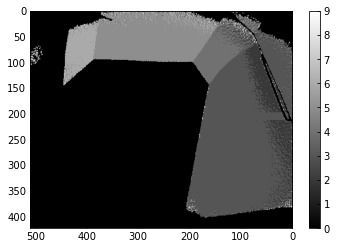

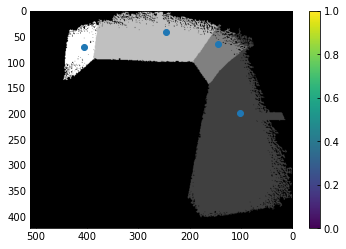

In [198]:
xyz_back_mean = postBase.convDepth2XYZ(mt, ds_back_mean)
nv_mean = postBase.calcNormal(xyz_back_mean)

arctan_mean = postBase.calcArctan(nv_mean) + 22.5*np.pi/180.0
arctan_mean = postBase.calcMinMaxScaling(arctan_mean, 9).astype('uint8')
fig, ax = plt.subplots()
plt.imshow(arctan_mean, cmap='gray')
ax.invert_xaxis()
plt.colorbar()
plt.show()

seedList = [
      [3, 101, 199]
    , [4, 144, 64]
    , [5, 245, 41]
    , [6, 406, 69]
#     , [7, 441, 199]
]

h, w = arctan_mean.shape[:2]
mask0 = np.zeros((h + 2, w + 2), dtype='uint8')
mask0[1:-1,1:-1] = arctan_mean
markers = np.zeros_like(arctan_mean, dtype='uint8')
for n, [val, i, j] in enumerate(seedList):
    mask = np.where(mask0 == val, 0, 1).astype('uint8')
    retval, markers, mask, rect = cv2.floodFill(markers, mask, seedPoint=(i, j), newVal=n+1)

fig, ax = plt.subplots()
plt.imshow(markers, cmap='gray')
plt.scatter([s[1] for s in seedList], [s[2] for s in seedList])
ax.invert_xaxis()
plt.colorbar()
plt.show()

### 側壁に該当する点群に対して，最小自乗法による平面の算出

In [199]:
param_plane = []
vec_plane = []
xyz_plane = []
for n in range(len(seedList)):
    d = np.where(markers == n+1, ds_back_mean, 0)
    count = d[d.nonzero()].size
    print('%d : count=%d' % (n, count))
    if count == 0:
        param_plane.append([])
        vec_plane.append([])
        xyz_plane.append([])
        continue
    #print(d[d.nonzero()])
    #base.writeXYZ(dirName0+'/plane_%02d.xyz' % (n), d, mapperTable)
    xyz = postBase.convDepth2XYZ(mt, d)
    xyz = xyz[xyz.nonzero()]
    xyz = xyz.reshape(xyz.size//3, 3)
    vec_normal, param = postBase.calcPlane(xyz)
    param_plane.append(param)
    vec_plane.append(vec_normal)
    xyz_plane.append(xyz)


0 : count=41498
mean=9.766581e-16, std=0.384172, count=41498
[ 0.91603635  0.23505666 -0.32500119  4.269678  ]
mean=-2.545298e-10, std=0.214185, count=28747
[ 0.91892307  0.23497347 -0.31680888  4.21196612]
mean=-5.062727e-10, std=0.122214, count=17784
[ 0.92023721  0.23571376 -0.31241399  4.1827226 ]
mean=-6.163184e-10, std=0.070038, count=10634
[ 0.92073844  0.23620418 -0.31056128  4.17050918]
mean=-1.290491e-15, std=0.039998, count=6208
[ 0.92092886  0.23640384 -0.30984393  4.16597652]
1 : count=5176
mean=-1.475909e-09, std=0.148619, count=5176
[-0.54329406  0.41978853  0.72705512 -7.45539297]
mean=-1.087902e-15, std=0.082927, count=3442
[-0.53852852  0.44098414  0.71799723 -7.42179781]
mean=-1.131330e-15, std=0.046670, count=2104
[-0.53454031  0.44933167  0.71579865 -7.41436929]
2 : count=17858
mean=8.637983e-10, std=0.057847, count=17858
[ 4.67074527e-04  8.24335828e-01  5.66100896e-01 -6.45064771e+00]
mean=5.594845e-10, std=0.027794, count=13890
[-5.66386146e-03  8.31497520e-01  

### 各平面の法線ベクトル，隣り合う2平面の交線ベクトルの算出

In [200]:
vec_intersection = []
pos_intersection = []
param_intersection = []
for n in range(len(seedList)-1):
    vec, pos, param = postBase.calcIntersection(param_plane[n], param_plane[n+1])
    vec_intersection.append(vec)
    pos_intersection.append(pos)
    param_intersection.append(param)

print('### plane normal vector ###')
for n, vec in enumerate(vec_plane):
    print(n, vec)
print('### intersection vector ###')
for n, vec in enumerate(vec_intersection):
    print(n, vec)


### plane normal vector ###
0 [ 0.91603635  0.23505666 -0.32500119]
1 [-0.54329406  0.41978853  0.72705512]
2 [4.67074527e-04 8.24335828e-01 5.66100896e-01]
3 [0.64678357 0.74741726 0.1517842 ]
### intersection vector ###
0 [ 0.39795886 -0.63376659  0.66330133]
1 [ 0.55391855 -0.47153241  0.68617157]
2 [ 0.41862765 -0.51427026  0.74851652]


### 算出したベクトルから変換行列を算出

In [201]:
# xvec = 0.5*(vec_intersection[0] + vec_intersection[3])
xvec = 0.5*(vec_intersection[0] + vec_intersection[2])
yvec1 = np.cross(xvec, vec_plane[2])
xvec = 0.5*(vec_intersection[1] + vec_intersection[2])
yvec2 = np.cross(xvec, vec_plane[2])
yvec = 0.5*(yvec1 + yvec2)
norm = np.linalg.norm(yvec)
yvec /= norm

zvec = vec_plane[2]
zvec = zvec - np.dot(zvec, yvec)*yvec
zvec = np.dot(postBase.rotation_mat(-2.6, yvec), zvec)
norm = np.linalg.norm(zvec)
zvec /= norm

xvec = np.cross(zvec, yvec)
norm = np.linalg.norm(xvec)
xvec /= norm

print('Vec Ave (X-axis) : ', xvec)
print('SideVec (Y-axis) : ', yvec)
print('VertVec (Z-axis) : ', zvec)

M = np.array([xvec, yvec, zvec])
inv_M = np.linalg.inv(M.T)
print('Transformation Matrix : ')
print(inv_M)
print('Transformation Matrix Check : ')
print(np.dot(inv_M, xvec.T))
print(np.dot(inv_M, yvec.T))
print(np.dot(inv_M, zvec.T))

transM = inv_M

Vec Ave (X-axis) :  [ 0.44913603 -0.54269937  0.70975645]
SideVec (Y-axis) :  [-0.89321978 -0.25418647  0.37087419]
VertVec (Z-axis) :  [0.0208627  0.80054146 0.59891411]
Transformation Matrix : 
[[ 0.44913603 -0.54269937  0.70975645]
 [-0.89321978 -0.25418647  0.37087419]
 [ 0.0208627   0.80054146  0.59891411]]
Transformation Matrix Check : 
[ 1.00000000e+00 -5.55111512e-17 -5.55111512e-17]
[0. 1. 0.]
[ 0.00000000e+00 -2.77555756e-17  1.00000000e+00]


In [202]:
print(vec_intersection)

[array([ 0.39795886, -0.63376659,  0.66330133]), array([ 0.55391855, -0.47153241,  0.68617157]), array([ 0.41862765, -0.51427026,  0.74851652])]


### XYZを変換行列で座標変換して描画

In [203]:
depths = {}
depths['ds_BF_front'] = ds_BF_front
depths['ds_BF'] = ds_BF
depths['ds_front'] = ds_front
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz0s = postBase.convDepth2XYZ(mt, depths[key][nFrame])
    xyz0s = [xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0]
    xyz0s = np.array(xyz0s, dtype='float32')
    
    xyz1s = postBase.convXYZbyMat(xyz0s, transM)
    
    point_cloud = pv.PolyData(xyz1s)
    display(point_cloud)

    pl = pv.PlotterITK()
    pl.add_mesh(point_cloud, scalars=np.array(xyz1s[:,2]), smooth_shading=True)
    #pl.add_mesh(point_cloud)
    pl.show(True)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

### YZ面上に点群を描画

In [270]:
def isInCircle(xyz, r, c):
    dxyz = np.abs(xyz - c)
    return dxyz[1] < r[1] and dxyz[2] < r[2]

def extractObject(depths):
    xyz0s = postBase.convDepth2XYZ(mt, depths)
    xyz0s = [xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0]
    xyz0s = np.array(xyz0s, dtype='float32')
    #print(0)
    
    xyz1s = postBase.convXYZbyMat(xyz0s, transM)
    #print(1)
    
    xyz2s = [xyz for xyz in xyz1s if 4.0 < xyz[0] and xyz[0] < 8]
    xyz2s = np.array(xyz2s, dtype='float32')
    #print(2)
    
    xyz_mean = np.mean(xyz2s, axis=0)
    xyz_std = np.std(xyz2s, axis=0)
    #print(3.0)
    
    xyz3s = [xyz for xyz in xyz2s if isInCircle(xyz, xyz_std*2, xyz_mean)]
    xyz3s = np.array(xyz3s, dtype='float32')
    #print(3.1)

    #xyz_mean = np.mean(xyz3s, axis=0)
    #xyz_std = np.std(xyz3s, axis=0)
    #xyz4s = [xyz for xyz in xyz3s if isInCircle(xyz, xyz_std*3, xyz_mean)]
    #xyz4s = np.array(xyz4s, dtype='float32')

    return [xyz3s, xyz_mean, xyz_std]

In [271]:
@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    print(xyz_mean)
    print(xyz_std)
    
    point_cloud = pv.PolyData(xyz3s)
    display(point_cloud)

    pl = pv.PlotterITK()
    pl.add_mesh(point_cloud, scalars=np.array(xyz3s[:,2]), smooth_shading=True)
    #pl.add_mesh(point_cloud)
    pl.show(True)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

area :  10395.134765625
radius : 57.52281429234195


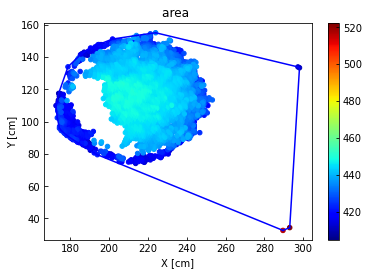

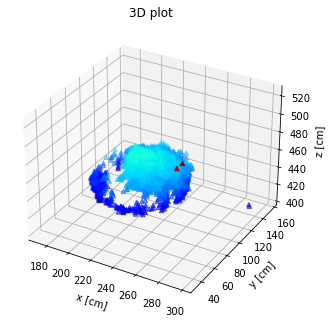

In [251]:
#myfix
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D

nframe = 116
xyz3s, _, _ = extractObject(depths["ds_BF_front"][nframe])
x = xyz3s[:,2] * 100
y = xyz3s[:,1] * 100
z = xyz3s[:,0] * 100


# ax = Axes3D(fig)

# #軸にラベルを付けたいときは書く
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")


#最後に.show()を書いてグラフ表示
# plt.show()


def polygon_area(x, y):
    return abs(sum(x[i]*y[i-1] - y[i]*x[i-1] for i in range(len(x)))) / 2

def calc_center_area(X, Y):
    array = []
    for x, y in zip(X, Y):
        array.append([x,y])
    array = np.array(array)
    hull = ConvexHull(array)
    x, y = [], []
    # simplex:array配列の結合部分のindex番号
    for simplex, vertice in zip(hull.simplices, hull.vertices):
        x.append(array[vertice][0])
        y.append(array[vertice][1])
    center_x, center_y = sum(x) / len(x), sum(y) / len(y)
    area = polygon_area(x, y)
    return center_x, center_y, area

def create_convex_map(X, Y, Z):
    array = []
    fig = plt.figure()
    ax = fig.add_subplot()
    for x, y in zip(X, Y):
        array.append([x,y])
    array = np.array(array)
    hull = ConvexHull(array)
    im = ax.scatter(X, Y, c=Z, label="key points", cmap="jet", s=20)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")
    ax.set_title("area ")
    #外周部分の座標配列
    x, y, countors = [], [], []
    # simplex:array配列の結合部分のindex番号
    for simplex, vertice in zip(hull.simplices, hull.vertices):
        countors.append([array[vertice][0], array[vertice][1]])
        x.append(array[vertice][0])
        y.append(array[vertice][1])
        ax.plot(array[simplex, 0], array[simplex, 1], c="blue")
    center_x, center_y = sum(x) / len(x), sum(y) / len(y)
#     ax.scatter(center_x, center_y, c="purple")
    area = polygon_area(x, y)
    radius = (area / np.pi) ** (0.5)
    print("area : ", polygon_area(x, y))
    print(f"radius : {radius}")   
    plt.colorbar(im,aspect=20, ax=ax)

create_convex_map(x, y, z)
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title("3D plot")
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

ax.scatter(x, y, z, c=z, marker="^", cmap="jet");#Kinect

In [273]:
@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
    z = xyz3s[:,0] * 100

    print(xyz_mean)
    print(xyz_std)
    
    create_convex_map(x, y, z)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

In [228]:
@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    print(xyz_mean)
    print(xyz_std)
    
    center, radius = postCore.minEnclosingCircle(xyz3s)
    print(f"center: {center}, radius: {radius}")
    
    plt.scatter(xyz3s[:,1], xyz3s[:,2], c=xyz3s[:,0], cmap='rainbow')
    plt.colorbar()
    
    ts = np.linspace(0, 2*np.pi, 50)
    x_circle = 3*xyz_std[1]*np.cos(ts) + xyz_mean[1]
    y_circle = 3*xyz_std[2]*np.sin(ts) + xyz_mean[2]
    plt.plot(x_circle, y_circle)
    
    x_circle = radius*np.cos(ts) + center[0]
    y_circle = radius*np.sin(ts) + center[1]
    plt.plot(x_circle, y_circle)
    
    plt.show()

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

### 凸包による形状の算出

In [279]:
cs = []
rs = []
areas = []
for i, d in enumerate(ds_BF_front):
    xyz3s, xyz_mean, xyz_std = extractObject(d)
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
   
    #外接円を使用する場合は下
#     center, radius = postCore.minEnclosingCircle(xyz3s * 100)
    center_x, center_y, area = calc_center_area(x, y)
    radius = (area / np.pi) ** (0.5)
    print(i, (center_x, center_y), area, radius)
    cs.append((center_x, center_y))
    rs.append(radius)
    areas.append(area)

0 (231.36307416643416, 134.21239335196358) 4757.876953125 38.916311123045816
1 (216.92972479926215, 126.68126890394423) 7115.6845703125 47.59193992364597
2 (226.08903107819734, 128.3790907683196) 4816.97265625 39.15724732359732
3 (220.5992957221137, 124.25904394079137) 4899.3671875 39.49072057870968
4 (216.52290289742606, 127.21402359008789) 4739.8056640625 38.84233517003092
5 (215.03592710141783, 121.48586584020543) 4830.2109375 39.211017504769316
6 (209.9384514593309, 121.46049499511719) 4812.046875 39.137221325642365
7 (209.34463562011717, 116.37038360595703) 4902.26708984375 39.50240599521385
8 (209.35843811035156, 117.96795196533203) 4837.03955078125 39.23872460816832
9 (210.94923305511475, 110.26151847839355) 4751.96533203125 38.892127018050665
10 (197.78579345703125, 110.45166717529297) 5974.5517578125 43.609160620544664
11 (204.16244389460638, 107.93709006676308) 4955.14208984375 39.71486767751688
12 (205.25828842889695, 105.64378756568546) 5005.07470703125 39.91446805779186
13

5477.00564453125


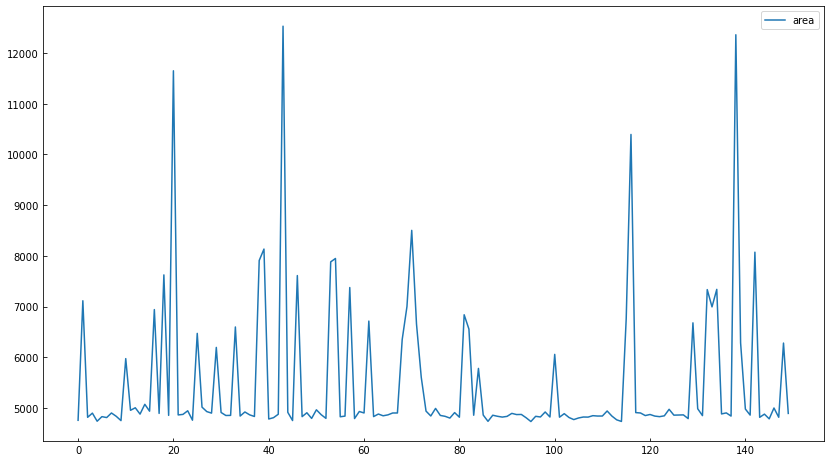

In [288]:
print(sum(areas) / len(areas))
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(frames, areas, label="area");
plt.legend()

41.49572238427383 [214.11314513 108.91601195]
4.635738036817511 [10.03479943  8.64706565]


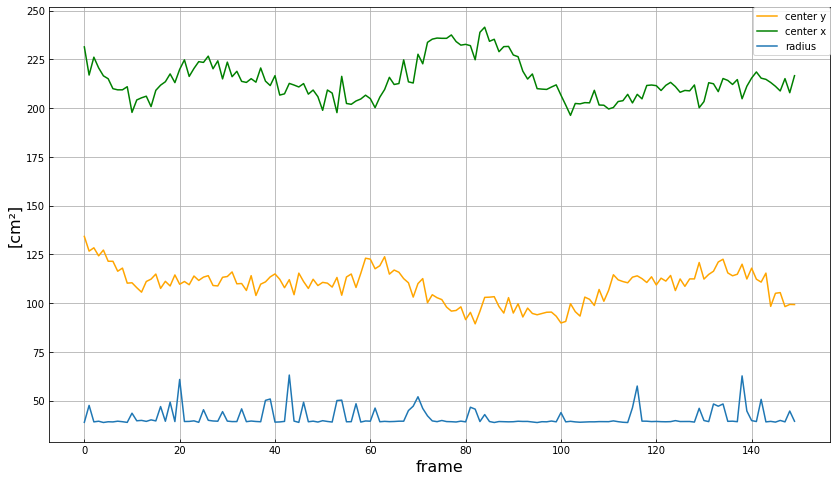

In [275]:
rs = np.array(rs)
cs = np.array(cs)
areas = np.array(areas)
print(rs.mean(), cs.mean(axis=0))
print(rs.std(), cs.std(axis=0))

frames = range(len(ds[1]))
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(frames, cs[:,1], label='center y', c="orange")
ax.plot(frames, cs[:,0], label='center x', c="green")
ax.plot(frames, rs, label='radius')
ax.set_xlabel('frame', fontsize=16)
ax.set_ylabel('[cm²]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid()
plt.show()


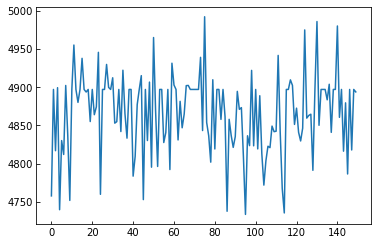

In [265]:
# ノイズの除去
areas[areas >= 5000] = areas.mean()
plt.plot(range(len(areas)), areas)

## 外接円

In [247]:
cs = []
rs = []
areas = []
for i, d in enumerate(ds_BF_front):
    xyz3s, xyz_mean, xyz_std = extractObject(d)
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
   
    #外接円を使用する場合は下
    center, radius = postCore.minEnclosingCircle(xyz3s * 100)
#     center_x, center_y, area = calc_center_area(x, y)
    area = np.pi * radius ** 2 
    print(i, center, radius, area)
    cs.append(center)
    rs.append(radius)
    areas.append(area)

0 (135.73524475097656, 228.035888671875) 41.2440185546875 5344.066082689047
1 (163.76268005371094, 246.18528747558594) 75.65489196777344 17981.4166228901
2 (131.3903350830078, 226.73680114746094) 42.02943420410156 5549.539666188529
3 (128.27328491210938, 224.31027221679688) 42.48499298095703 5670.495033100493
4 (122.67584228515625, 222.13877868652344) 41.15570831298828 5321.205530404999
5 (122.66796112060547, 219.858642578125) 41.746421813964844 5475.053744523712
6 (120.7541732788086, 217.5331268310547) 42.93679428100586 5791.740637502378
7 (118.21456146240234, 219.6685028076172) 43.48592758178711 5940.83306780036
8 (116.09585571289062, 214.70330810546875) 41.85576629638672 5503.7724189508845
9 (115.55882263183594, 211.1430206298828) 42.20357894897461 5595.622861282761
10 (133.5604248046875, 219.2442169189453) 60.889442443847656 11647.530793253241
11 (112.62068176269531, 210.48316955566406) 42.35734558105469 5636.471886509243
12 (112.18524932861328, 211.1263885498047) 43.5754280090332 

In [253]:
print(sum(areas) / len(areas))

8345.966459052843


49.53676767985026 [112.14134343 224.34705566]
14.23770632887851 [15.23049692 14.86137175]


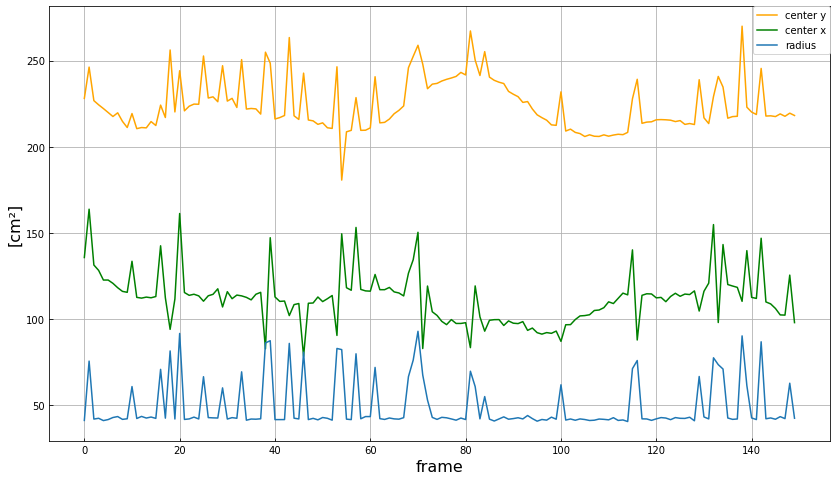

In [248]:
rs = np.array(rs)
cs = np.array(cs)
print(rs.mean(), cs.mean(axis=0))
print(rs.std(), cs.std(axis=0))

frames = range(len(ds[1]))
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(frames, cs[:,1], label='center y', c="orange")
ax.plot(frames, cs[:,0], label='center x', c="green")
ax.plot(frames, rs, label='radius')
ax.set_xlabel('frame', fontsize=16)
ax.set_ylabel('[cm²]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid()
plt.show()
